In [1]:
# Inv Setup
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
%cd

/root


In [11]:
# Import Data from Drive
%cp "/content/drive/My Drive/Gonçalo/IST/FIREFRONT/CNN/u-net_dataset.zip" "/content/u-net_dataset.zip"
%cd /content/
!unzip u-net_dataset.zip
%cp "/content/drive/My Drive/Gonçalo/IST/FIREFRONT/CNN/u-net.h5" "/content/u-net.h5" 

/content
Archive:  u-net_dataset.zip
   creating: u-net_dataset/
   creating: u-net_dataset/test/
   creating: u-net_dataset/test/images/
   creating: u-net_dataset/test/masks/
   creating: u-net_dataset/train/
   creating: u-net_dataset/train/images/
 extracting: u-net_dataset/train/images/1.png  
 extracting: u-net_dataset/train/images/10.png  
 extracting: u-net_dataset/train/images/100.png  
 extracting: u-net_dataset/train/images/101.png  
  inflating: u-net_dataset/train/images/102.png  
 extracting: u-net_dataset/train/images/103.png  
 extracting: u-net_dataset/train/images/104.png  
 extracting: u-net_dataset/train/images/105.png  
 extracting: u-net_dataset/train/images/106.png  
 extracting: u-net_dataset/train/images/107.png  
 extracting: u-net_dataset/train/images/108.png  
 extracting: u-net_dataset/train/images/109.png  
 extracting: u-net_dataset/train/images/11.png  
 extracting: u-net_dataset/train/images/110.png  
 extracting: u-net_dataset/train/images/111.png  
 e

In [0]:
shutil.rmtree('u-net_dataset')

In [0]:
import os
import shutil
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [0]:
# Set some parameters
im_width = 128
im_height = 128
border = 5
path_train = 'content/u-net dataset/train/'
path_test = 'content/u-net dataset/test/'

In [14]:
# Get and resize train images and masks
ids = next(os.walk('u-net_dataset/train/images')) # list of names all images in the given path
ids = ids[2]
print("No. of images = ", len(ids))

No. of images =  908


In [0]:
X = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [16]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("u-net_dataset/train/images/"+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, 3))
    # Load masks
    mask = img_to_array(load_img("u-net_dataset/train/masks/"+id_, grayscale=True))
    mask = resize(mask, (im_width, im_height, 1))
    # Save images
    X[n] = x_img/255
    y[n] = mask/255

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2018)


Text(0.5, 1.0, 'Mask')

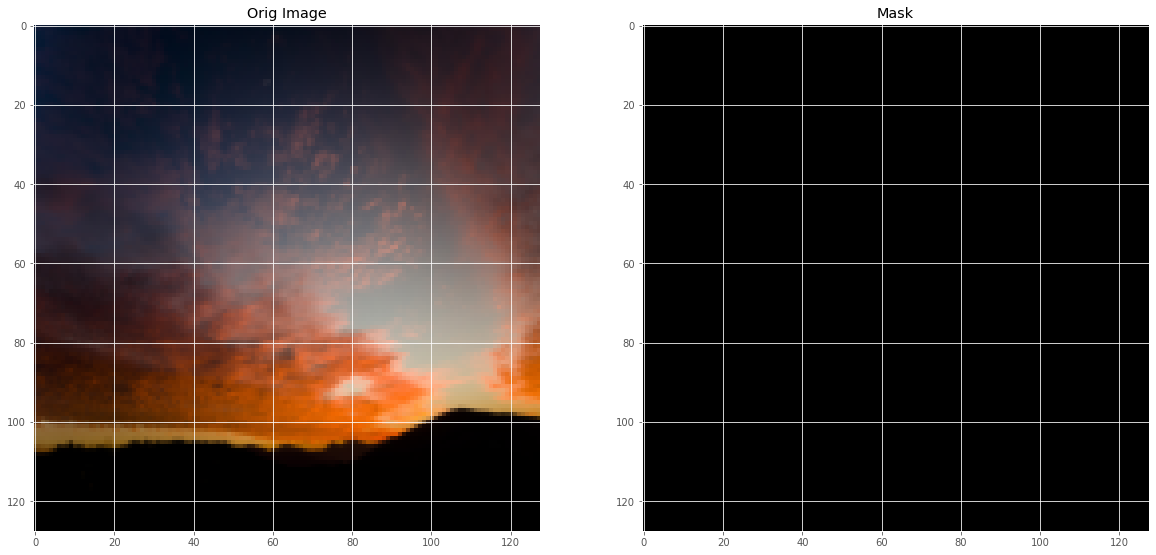

In [36]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(array_to_img(X_train[ix]))

if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Orig Image')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask')


In [0]:
print(X_train[ix])

In [0]:
# Build U-Net model
inputs = Input((im_height, im_width, 3))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

input_img = Input((im_height, im_width, 1), name='img')
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])



In [0]:
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


In [0]:
callbacks = [
    EarlyStopping(patience=20, verbose=1, min_delta=0),
    ModelCheckpoint('u-net1.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
]


In [0]:
results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks, validation_data=(X_valid, y_valid))


In [49]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

  
print(results.history.keys())
display_training_curves(results.history['accuracy'], results.history['val_accuracy'], 'accuracy', 211)
display_training_curves(results.history['loss'], results.history['val_loss'], 'loss', 212)


NameError: ignored

In [0]:
# Load best model
model = load_model("u-net1.h5")


In [53]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)


137/137 [==============================] - 5s 39ms/step


[0.1388564716725454, 0.8864269256591797]

In [0]:
#Binarization threshold
threshold = 0.5

In [71]:
# Predict on train, val and test

preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > threshold ).astype(np.uint8)
preds_val_t = (preds_val > threshold ).astype(np.uint8)


137/137 [==============================] - 5s 38ms/step


In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(array_to_img(X[ix]))
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Orig. Image + Mask contour')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Prediction Heat Map + Mask contour')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted binary + Mask contour');


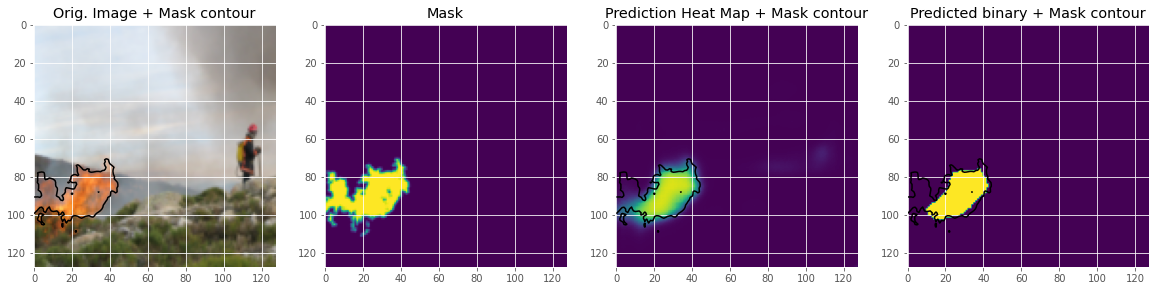

In [57]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=168)


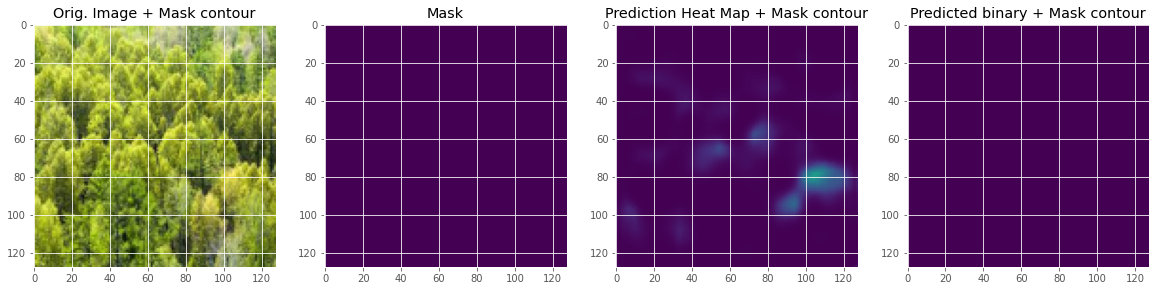

In [58]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)


In [0]:
%cp "/content/u-net1.h5" "/content/drive/My Drive/Gonçalo/IST/FIREFRONT/CNN/u-net1.h5"

--2020-05-06 03:45:10--  https://media.apnarm.net.au/media/images/2019/11/15/b882163712z1_20191115194454_001giv1naocb2-0-ryxumnwvcy066x6tbt2_fct2419x1354x119_t1880.jpg
Resolving media.apnarm.net.au (media.apnarm.net.au)... 13.249.87.46, 13.249.87.105, 13.249.87.20, ...
Connecting to media.apnarm.net.au (media.apnarm.net.au)|13.249.87.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67196 (66K) [image/jpeg]
Saving to: ‘b882163712z1_20191115194454_001giv1naocb2-0-ryxumnwvcy066x6tbt2_fct2419x1354x119_t1880.jpg.1’

b882163712z1_201911 100%[===================>]  65.62K  --.-KB/s    in 0.02s   

2020-05-06 03:45:10 (4.12 MB/s) - ‘b882163712z1_20191115194454_001giv1naocb2-0-ryxumnwvcy066x6tbt2_fct2419x1354x119_t1880.jpg.1’ saved [67196/67196]



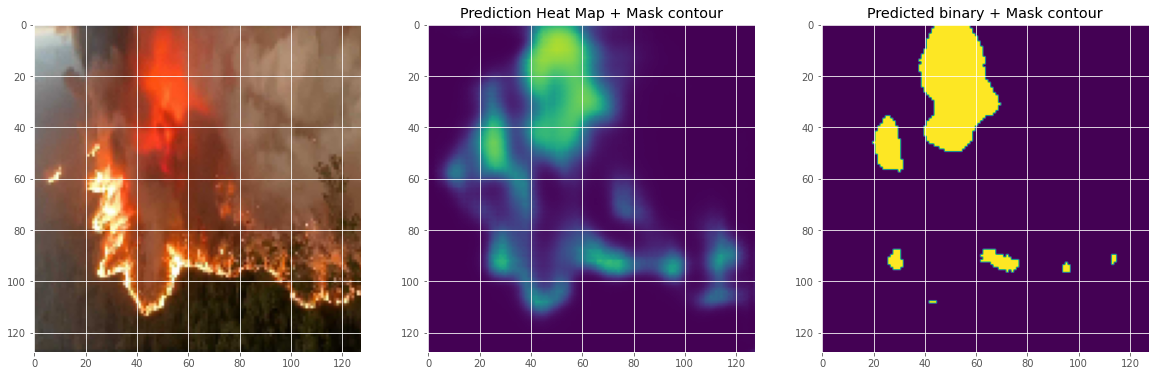

In [74]:
#Predictions on images outside dataset
from keras.preprocessing import image
!wget "https://media.apnarm.net.au/media/images/2019/11/15/b882163712z1_20191115194454_001giv1naocb2-0-ryxumnwvcy066x6tbt2_fct2419x1354x119_t1880.jpg"

img = image.load_img("b882163712z1_20191115194454_001giv1naocb2-0-ryxumnwvcy066x6tbt2_fct2419x1354x119_t1880.jpg",target_size=(im_height,im_width))
img = np.asarray(img)
x_img = np.expand_dims(img, axis=0)

prediction = model.predict(x_img/255)
pred_bin = (prediction > threshold).astype(np.uint8)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(array_to_img(img))

ax[1].imshow(prediction.squeeze(), vmin=0, vmax=1)
ax[1].set_title('Prediction Heat Map + Mask contour')

ax[2].imshow(pred_bin.squeeze(), vmin=0, vmax=1)
ax[2].set_title('Predicted binary + Mask contour');
    




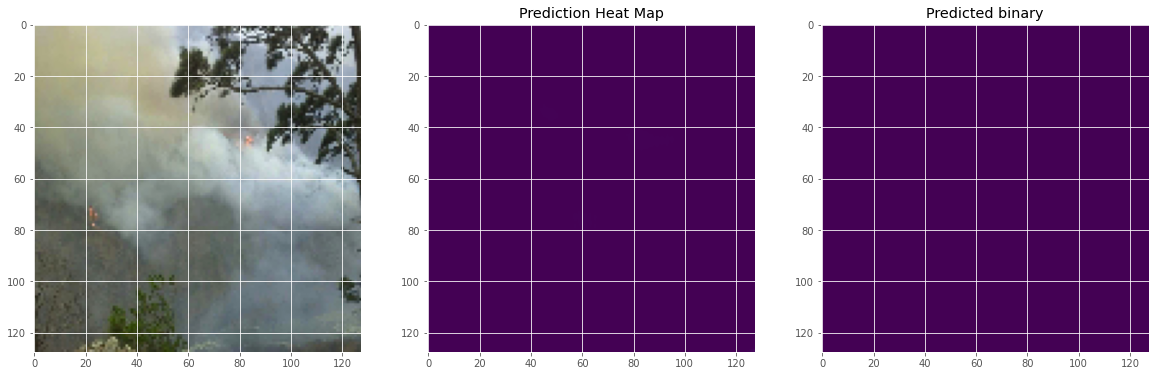

In [89]:
from keras.preprocessing import image
img = image.load_img("handmade_317.jpg",target_size=(im_height,im_width))
img = np.asarray(img)
x_img = np.expand_dims(img, axis=0)

prediction = model.predict(x_img/255)
pred_bin = (prediction > threshold).astype(np.uint8)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(array_to_img(img))

ax[1].imshow(prediction.squeeze(), vmin=0, vmax=1)
ax[1].set_title('Prediction Heat Map')

ax[2].imshow(pred_bin.squeeze(), vmin=0, vmax=1)
ax[2].set_title('Predicted binary');
    